# Library Import and Functions

# Summary Stats for New Genes and Transcripts


### - Figure S2

### - Total number of transcripts and genes across CPM threshold

### - Figure 4

### - Figure 5 & S1

### - Figure 3

### - Figure 2

### - Figure 6

### - Figure S3

### - Figure 7

### - Memes for figures

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes_02-04-2023_UPDATED.tsv", sep="\t")

## Brain disease genes
brain_disease_gene_ids = pd.read_csv("../../../references/bernardo/brain_disease_genes_only_IDs.tsv", sep="\t")
brain_disease_annotations = pd.read_csv("../../../references/bernardo/brain_disease_genes_with_disease.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

# - Figure S2

In [8]:
## Fix column names in counts matrix

df = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [9]:
ref_transcripts.loc[ref_transcripts["gene_id"].str.startswith("BambuGene290099")]

,chr,source,type,start,end,strand,gene_id,transcript_id,exon_number
1820173,GL000214.1,Bambu,transcript,125344.0,132784.0,-,BambuGene290099,BambuTx1940,NaN
1820174,GL000214.1,Bambu,transcript,125344.0,133145.0,-,BambuGene290099,BambuTx2703,NaN
1820177,GL000214.1,Bambu,transcript,126479.0,133333.0,-,BambuGene290099,BambuTx1941,NaN


In [10]:
## Calculate total counts and fix gene id
df["total_counts"] = df[df.filter(regex='count').columns].sum(axis=1)

In [11]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [12]:
## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [13]:
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [14]:
df = df.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [15]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [16]:
## Drop new mitochondrial transcripts/genes
df_novel_genes = df_novel_genes.loc[df_novel_genes["chr"] != "MT"].copy()
df_novel_transcripts = df_novel_transcripts.loc[df_novel_transcripts["chr"] != "MT"].copy()

In [17]:
## Filter novel genes and transcripts, one only total CPM > 1, other each CPM > 1

df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

In [18]:
## Only keep exon entries and add size variable
ref_exons = ref.loc[ref["type"] == "exon"].copy()
ref_exons["size"] = abs(ref_exons["end"] - ref_exons["start"])

In [19]:
## Get reference for novel genes and transcripts at each threshold
ref_novel_gene_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_median["transcript_id"])].copy()
ref_novel_transcript_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_median["transcript_id"])].copy()


ref_novel_gene = ref_exons.loc[ref_exons["gene_id"].str.startswith("BambuGene")].copy()
ref_novel_transcript = ref_exons.loc[((ref_exons["transcript_id"].str.startswith("BambuTx")) & 
                                      (~ref_exons["gene_id"].str.startswith("BambuGene")))].copy()

In [20]:
## get number of exons for each threshold
ref_novel_gene_median_num_exons = ref_novel_gene_median["transcript_id"].value_counts()
ref_novel_transcript_median_num_exons = ref_novel_transcript_median["transcript_id"].value_counts()

ref_novel_gene_num_exons = ref_novel_gene["transcript_id"].value_counts()
ref_novel_transcript_num_exons = ref_novel_transcript["transcript_id"].value_counts()

In [21]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

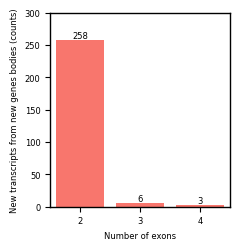

In [22]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_gene_median_num_exons, color=ggplot2_colors[0], saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 300)

plt.xlabel("Number of exons")
plt.ylabel("New transcripts from new genes bodies (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntng_median_cpm_greater_than_1.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntng_median_cpm_greater_than_1.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

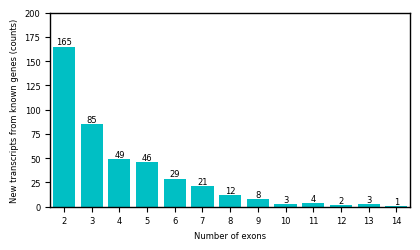

In [23]:
## Make average CPM > 1 transcript number of exons plot and save both as png and svg.

# figure size in mm
rcParams['figure.figsize'] = (118*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

ax = sns.countplot(x=ref_novel_transcript_median_num_exons, color=ggplot2_colors[4], saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 200)

plt.xlabel("Number of exons")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntkg_median_cpm_greater_than_1.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntkg_median_cpm_greater_than_1.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

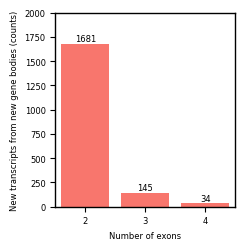

In [24]:
## Make no filter gene body number of exons plot and save both as png and svg.


# figure size in mm
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

ax = sns.countplot(x=ref_novel_gene_num_exons, color=ggplot2_colors[0], saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 2000)


plt.xlabel("Number of exons")
plt.ylabel("New transcripts from new gene bodies (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntng_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntng_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

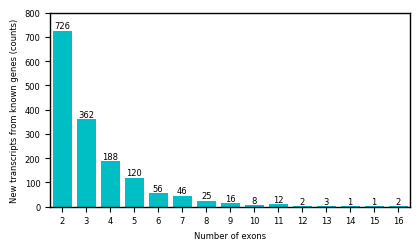

In [25]:
## Make no filter transcript number of exons plot and save both as png and svg.

# figure size in mm
rcParams['figure.figsize'] = (118*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

ax = sns.countplot(x=ref_novel_transcript_num_exons, color=ggplot2_colors[4], saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 800)


plt.xlabel("Number of exons")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntkg_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/num_exons_ntkg_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [26]:
# figure size in mm
rcParams['figure.figsize'] = (59*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [27]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_genes_median = ref_novel_gene_median[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_median = ref_novel_transcript_median[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes = ref_novel_gene[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts = ref_novel_transcript[["transcript_id", "size"]].groupby('transcript_id').sum()

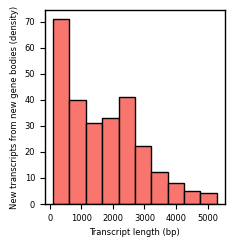

In [28]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_genes_median["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from new gene bodies (density)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntng_length_median_cpm_greater_than_one.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntng_length_median_cpm_greater_than_one.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

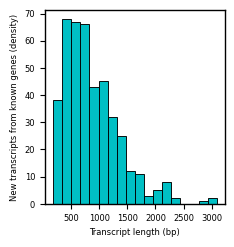

In [29]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts_median["size"], color=ggplot2_colors[4], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from known genes (density)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_median_cpm_greater_than_one.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_median_cpm_greater_than_one.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

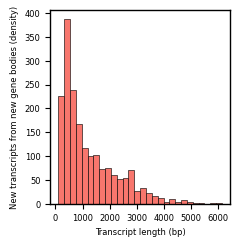

In [30]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_genes["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from new gene bodies (density)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntng_length_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntng_length_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

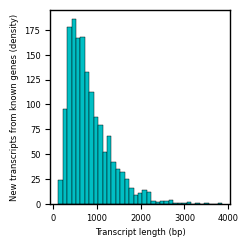

In [31]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts["size"], color=ggplot2_colors[4], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from known genes (density)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

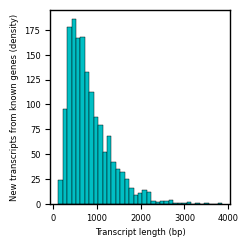

In [32]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts["size"], color=ggplot2_colors[4], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from known genes (density)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/histogram_ntkg_length_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [33]:
## Create log transformation of median CPM for new genes and transcripts

df_novel_genes_no_zero = df_novel_genes.loc[df_novel_genes["median_CPM"] > 0].copy()
log_10_median_cpm_genes = np.log10(df_novel_genes_no_zero["median_CPM"])

df_novel_transcripts_no_zero = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] > 0].copy()
log_10_median_cpm_transcripts = np.log10(df_novel_transcripts_no_zero["median_CPM"])

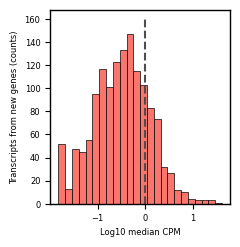

In [34]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=log_10_median_cpm_genes, color=ggplot2_colors[0], alpha=1)

plt.plot([0, 0], [0, 160], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')

plt.xlabel("Log10 median CPM")
plt.ylabel("Transcripts from new genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/median_cpm_histogram_new_genes.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/median_cpm_histogram_new_genes.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

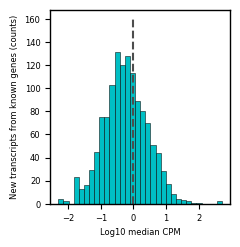

In [35]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=log_10_median_cpm_transcripts, color=ggplot2_colors[4], alpha=1)

plt.plot([0, 0], [0, 160], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')

plt.xlabel("Log10 median CPM")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/median_cpm_histogram_new_transcripts.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s2/median_cpm_histogram_new_transcripts.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# -Figure 4

In [36]:
rcParams['figure.figsize'] = (88.5*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [37]:
df_novel_genes_each = df_novel_genes[(df_novel_genes[df_novel_genes.columns[2:14]]>1).sum(axis=1)>=4].copy()
df_novel_transcripts_each = df_novel_transcripts[(df_novel_transcripts[df_novel_genes.columns[2:14]]>1).sum(axis=1)>=4].copy()

In [38]:
print(df_novel_genes_each.shape[0])
print(df_novel_transcripts_each.shape[0])

522
631


In [39]:
## Get number of transcripts from each filter from each filter

print("Number of transcripts mapping to new gene bodies (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of new transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (no filter): 1860
Number of transcripts mapping to new gene bodies (median CPM > 1): 267


Number of new transcripts mapping to annotated genes (no filter): 1534
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [40]:
## Get number of genes represented for each filter

print("Number of new genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with new transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (no filter): 1676
Number of new genes represented (median CPM > 1): 245


Number of represented annotated genes with new transcripts (no filter): 1255
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [41]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntkg_median = []
list_ntkg_median_prot_coding = []
list_ntkg_median_med_relevant = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntkg_median_cpm = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] >= cpm_thresh].copy()
    ntkg_median_cpm_num = ntkg_median_cpm.shape[0]
    ntkg_median_cpm_num_prot = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(protein_coding_ref["gene_id"])].shape[0]    
    ntkg_median_cpm_num_med = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(disease_relevant_genes_annotated["gene_id"])].shape[0]    
    
    list_cpm_thresh.append(cpm_thresh)
        
    list_ntkg_median.append(ntkg_median_cpm_num)
    list_ntkg_median_prot_coding.append(ntkg_median_cpm_num_prot)
    list_ntkg_median_med_relevant.append(ntkg_median_cpm_num_med)

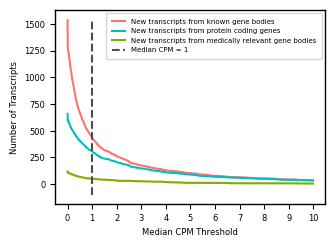

In [42]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntkg_median, color=ggplot2_colors[0], label="New transcripts from known gene bodies", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_prot_coding, color=ggplot2_colors[4], label="New transcripts from protein coding genes", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_med_relevant, color=ggplot2_colors[2], label="New transcripts from medically relevant gene bodies", linewidth=1.5, alpha=1)
plt.plot([1, 1], [-100, 1550], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=5, borderpad=0.8)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/number_of_new_transcripts_across_cpm_thresh.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/number_of_new_transcripts_across_cpm_thresh.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [43]:
## Import Data
df_events = pd.read_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/novel_events.tsv", sep="\t")

In [44]:
## Remove new genes
df_events = df_events.loc[df_events["txClassDescription"] != "newGene-spliced"].copy()

In [45]:
## Cleanup net transcript classes
df_events.loc[df_events["txClassDescription"] == "newWithin", "txClassDescription"] = "New combination of known exons/junctions"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newFirstExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newLastExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "allNew", "txClassDescription"] = "All new exons & junctions"

df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction", "txClassDescription"] = "New junction"


df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "New first exon & new junction", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newLastExon", "txClassDescription"] = "New exon & new junction"


In [46]:
## Create dataframes for the two stringency thresholds
df_events_median = df_events.loc[df_events["TXNAME"].isin(df_novel_transcripts_median["transcript_id"])]

In [47]:
## Get counts of events no filter
df_events["txClassDescription"].value_counts()

All new exons & junctions                   853
New junction                                266
New combination of known exons/junctions    197
New exon & new junction                     137
New exon                                    115
Name: txClassDescription, dtype: int64

In [48]:
## Get counts of events avg CPM > 1
df_events_median["txClassDescription"].value_counts()

All new exons & junctions                   186
New junction                                 94
New combination of known exons/junctions     92
New exon & new junction                      28
New exon                                     28
Name: txClassDescription, dtype: int64

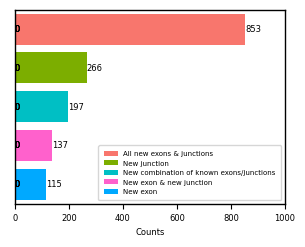

In [49]:
## Make graph of new transcript events for no filter

ax = sns.countplot(y=df_events["txClassDescription"], hue=df_events["txClassDescription"], dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[2], ggplot2_colors[4], ggplot2_colors[7], ggplot2_colors[5]], saturation=1,
                  order=df_events["txClassDescription"].value_counts().index, hue_order=df_events["txClassDescription"].value_counts().index)


for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 1000)

plt.tick_params(labelsize=None)

plt.legend(loc="lower right", fontsize=5, borderpad=0.8)
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/barplot_events_new_transcripts_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/barplot_events_new_transcripts_no_filter.svg',
           dpi=1200, transparent=True, bbox_inches="tight")

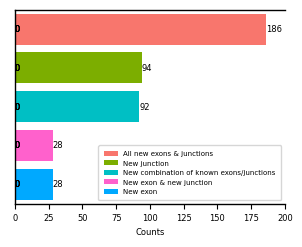

In [50]:
## Make graph of new transcript events for no filter

ax = sns.countplot(y=df_events_median["txClassDescription"], hue=df_events_median["txClassDescription"], dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[2], ggplot2_colors[4], ggplot2_colors[7], ggplot2_colors[5]],
                   saturation=1, order=df_events_median["txClassDescription"].value_counts().index,
                  hue_order=df_events_median["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 200)

sns.despine(ax=ax, top=False, right=True, left=False, bottom=False, offset=None, trim=False)

plt.yticks(rotation=90)
plt.tick_params(labelsize=None)

plt.legend(loc="lower right", fontsize=5, borderpad=0.8)
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/barplot_events_new_transcripts_median_cpm_greater_than_one.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/barplot_events_new_transcripts_median_cpm_greater_than_one.svg',
           dpi=1200, transparent=True, bbox_inches="tight")

# Figures 5 & S1

In [51]:
## Create list o disease relevant novel transcripts for three stringency thresholds
novel_relevant = df_novel_transcripts.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [52]:
## Create list of novel transcripts belonging to protein coding genes for three stringency thresholds
protein_relevant = df_novel_transcripts.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

protein_relevant_median = df_novel_transcripts_median.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                            on=["gene_id"], how="inner")

In [53]:
## Drop any duplicates
novel_relevant.drop_duplicates(inplace=True)
novel_relevant_median.drop_duplicates(inplace=True)

protein_relevant.drop_duplicates(inplace=True)
protein_relevant_median.drop_duplicates(inplace=True)

In [54]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_counts = pd.merge(df, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

protein_relevant_counts = pd.merge(df, protein_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_median_counts = pd.merge(df, protein_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")


In [55]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)

protein_relevant_relative_abundance = relative_transcript_abundance(protein_relevant_counts)
protein_relevant_median_relative_abundance = relative_transcript_abundance(protein_relevant_median_counts)


In [56]:
## Annotate novel transcripts on relative abundance table
novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_relative_abundance.loc[~novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False



protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_relative_abundance.loc[~protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_median_relative_abundance.loc[protein_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_median_relative_abundance.loc[~protein_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [57]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()


protein_relevant_words = protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_median_words = protein_relevant_median_relative_abundance.loc[protein_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()


In [58]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()

protein_relevant_words = protein_relevant_words.drop_duplicates()
protein_relevant_median_words = protein_relevant_median_words.drop_duplicates()

In [59]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

protein_relevant_words = round(protein_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_median_words = round(protein_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [60]:
## Create a dataframe to properly store the data
novel_relevant_words_df = pd.DataFrame()
novel_relevant_words_df['word_count'] = novel_relevant_words
novel_relevant_words_df["gene_name"] = novel_relevant_words.index

novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

protein_relevant_words_df = pd.DataFrame()
protein_relevant_words_df['word_count'] = protein_relevant_words
protein_relevant_words_df["gene_name"] = protein_relevant_words.index

protein_relevant_median_words_df = pd.DataFrame()
protein_relevant_median_words_df['word_count'] = protein_relevant_median_words
protein_relevant_median_words_df["gene_name"] = protein_relevant_median_words.index

In [61]:
## Drop index
novel_relevant_words_df.reset_index(inplace=True, drop=True)
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)


protein_relevant_words_df.reset_index(inplace=True, drop=True)
protein_relevant_median_words_df.reset_index(inplace=True, drop=True)

In [62]:
novel_relevant_median_words_df.shape[0]

49

In [63]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (No Filter):", novel_relevant_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())


print("\n\nNumber of protein coding genes with novel transcripts (No Filter):", protein_relevant_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (median CPM > 1):", protein_relevant_median_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (No Filter): 101
Number of medically relevant genes with novel transcripts (median CPM > 1): 49


Number of protein coding genes with novel transcripts (No Filter): 540
Number of protein coding genes with novel transcripts (median CPM > 1): 263


In [64]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant no filter

word_list_disease = ""

for i in range(len(novel_relevant_words_df)):
        
    for j in range(int(novel_relevant_words_df.iloc[i][0])):
        word_list_disease = word_list_disease + novel_relevant_words_df.iloc[i][1] + " "

In [65]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [66]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant no filter

word_list_protein = ""

for i in range(len(protein_relevant_words_df)):
        
    for j in range(int(protein_relevant_words_df.iloc[i][0])):
        word_list_protein = word_list_protein + protein_relevant_words_df.iloc[i][1] + " "

In [67]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant median CPM > 1

word_list_protein_median = ""

for i in range(len(protein_relevant_median_words_df)):
        
    for j in range(int(protein_relevant_median_words_df.iloc[i][0])):
        word_list_protein_median = word_list_protein_median + protein_relevant_median_words_df.iloc[i][1] + " "

In [68]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [69]:
## Generate wordclouds
word_cloud_disease = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease)

word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_median)



word_cloud_protein = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein)

word_cloud_protein_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_median)

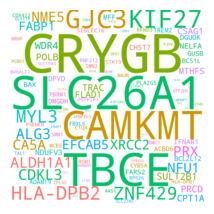

In [70]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/word_cloud_disease_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/word_cloud_disease_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

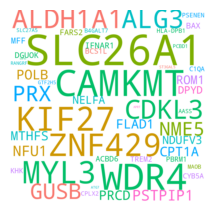

In [71]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/word_cloud_disease_median.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/word_cloud_disease_median.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

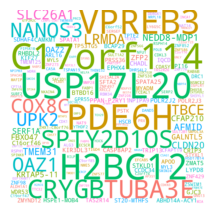

In [72]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_protein, interpolation='bilinear')
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s1/word_cloud_protein_no_filter.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s1/word_cloud_protein_no_filter.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

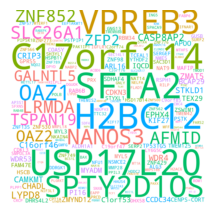

In [73]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_protein_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s1/word_cloud_protein_median.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_s1/word_cloud_protein_median.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [74]:
## Export lists of protein coding genes with novel transcripts and disease relevant genes with novel transcripts
## at median CPM > 1 and each CPM > 1

novel_relevant_median_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/medically_relevant_median_cpm.tsv",
                                  sep="\t", index=False)


protein_relevant_median_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/protein_coding_median_cpm.tsv",
                                  sep="\t", index=False)

# - Figure 3

In [75]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [76]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [77]:
## Create unique identifier for protein id
unique_protein_id = pd.DataFrame()
string_orig_ref_cds = orig_ref_cds[['protein_id', 'start', 'end']].copy().astype(str)

unique_protein_id = string_orig_ref_cds.groupby(['protein_id'])[["protein_id", "start", "end"]].transform(lambda x: '-'.join(x))

unique_protein_id["protein_id"] = unique_protein_id["protein_id"].str.split("-", expand=True)[0]
unique_protein_id["unique_identifier"] = "Start coordinates: " + unique_protein_id["start"].copy() + "   End coordinates:" + unique_protein_id["end"].copy()
unique_protein_id = unique_protein_id[["protein_id", "unique_identifier"]].copy()
unique_protein_id.drop_duplicates(inplace=True)
unique_protein_id = unique_protein_id.merge(orig_ref_cds["transcript_id"], left_index=True, right_index=True)

orig_ref_cds = orig_ref_cds.merge(unique_protein_id, on=["protein_id", "transcript_id"], how="inner")
orig_ref_cds["protein_id"] = orig_ref_cds["unique_identifier"].copy()
orig_ref_cds.drop(columns="unique_identifier", inplace=True)

In [78]:
ref_cds = orig_ref_cds.loc[~orig_ref_cds["protein_id"].isna()].copy()

ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [79]:
## Create dataframes for AD and med relevant genes, drop Mitochondria
df_med_relevant = df.merge(disease_relevant_genes, on="gene_id", how="inner")
df_med_relevant = df_med_relevant.loc[df_med_relevant["chr"] != "MT"].copy()

df_brain_relevant = df_med_relevant.merge(brain_disease_gene_ids["gene_id"], on="gene_id", how="inner")

df_ad = df.merge(ad_names, on="gene_id", how="inner")
df_ad = df_ad.loc[df_ad["chr"] != "MT"].copy()

In [80]:
## Only keep protein coding transcripts in expression matrix, adding protein_ids
df_prot_coding_ccds = df.merge(ref_cds[["transcript_id", "protein_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [81]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_genes_all_median = []
list_genes_proteins_median = []
list_genes_med_relevant_median = []
list_genes_med_relevant_proteins_median = []
list_brain_relevant_median = []
list_brain_relevant_proteins_median = []
list_genes_ad_median = []
list_genes_ad_proteins_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    df_gene_multiple_all = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] >= cpm_thresh].copy()

    
    df_gene_multiple_prot = df_gene_multiple_prot.loc[~df_gene_multiple_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()

    
    num_genes_multiple_isoforms = df_gene_multiple_all.loc[df_gene_multiple_all.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_genes_multiple_prot = df_gene_multiple_prot["gene_id"].nunique()

    list_cpm_thresh.append(cpm_thresh)
    
    list_genes_all_median.append(num_genes_multiple_isoforms)
    list_genes_proteins_median.append(num_genes_multiple_prot)

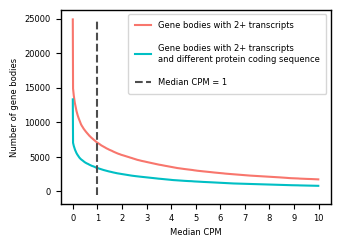

In [82]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_genes_all_median, color=ggplot2_colors[0], label="Gene bodies with 2+ transcripts", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_genes_proteins_median, color=ggplot2_colors[4], label="\nGene bodies with 2+ transcripts \nand different protein coding sequence\n", linewidth=1.5, alpha=1)

plt.plot([1, 1], [-500, 25000], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM')
plt.ylabel('Number of gene bodies')
plt.legend(loc="upper right", borderpad=0.8)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/A.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/A.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [83]:
## Create CPM 1 Threhold multiple isoform filter
df_multiple_iso = df.loc[df["median_CPM"] > 1].copy()
df_multiple_iso = df_multiple_iso.loc[df_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_num_isoforms = df_multiple_iso["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_multiple_iso = pd.DataFrame()
df_num_multiple_iso["Number of gene bodies"] = df_num_isoforms.value_counts()
df_num_multiple_iso["Number of transcripts"] = df_num_isoforms.value_counts().index
df_num_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_isoforms_six = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_isoforms_six = df_num_isoforms_six.groupby("Category").sum()
df_num_isoforms_six["Number of transcripts"] = "6+"
df_num_isoforms_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_multiple_iso = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] < 6].copy()
df_num_multiple_iso["Number of transcripts"] = df_num_multiple_iso["Number of transcripts"].astype(str)
df_num_multiple_iso = pd.concat([df_num_multiple_iso, df_num_isoforms_six])

In [84]:
## Create CPM 1 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()

df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_gene_mutiple_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of gene bodies"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_avg["Number of transcripts"] = df_numbers_prot_multiple_isoforms_median.value_counts().index
df_num_isoforms_prot_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_six = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_six = df_num_isoforms_prot_six.groupby("Category").sum()
df_num_isoforms_prot_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_avg = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_avg["Number of transcripts"] = df_num_isoforms_prot_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_avg = pd.concat([df_num_isoforms_prot_avg, df_num_isoforms_prot_six])

In [85]:
## Make list with number genes with 2+ isoforms with median CPM > 1 for Mark
df_num_isoforms = df_multiple_iso["gene_id"].value_counts().rename_axis('gene_id').reset_index(name='number_of_isoforms')
df_num_isoforms = df_num_isoforms.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")
df_num_isoforms.to_csv("~/genes_with_multiple_isoforms_median_CPM_greater_than_one_frontal_cortex.csv",
                      index=False)

In [86]:
## Concatenate
df_number_isoforms_per_gene = pd.concat([df_num_multiple_iso, df_num_isoforms_prot_avg])

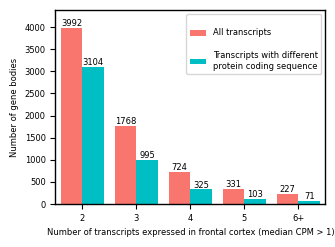

In [87]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True)


# replace labels
legend = ax.legend()
legend.texts[0].set_text("\nAll transcripts\n")
legend.texts[1].set_text("Transcripts with different\nprotein coding sequence")
    
ax.set(ylim=(0, 4400), xlim=(-0.5, 4.5))
plt.ylabel("Number of gene bodies")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])    


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/B.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/B.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [88]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_mutiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_med = df_gene_mutiple_med.loc[df_gene_mutiple_med.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_median = df_gene_mutiple_med["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_med_multiple_iso = pd.DataFrame()
df_num_med_multiple_iso["Number of gene bodies"] = df_numbers_med_multiple_isoforms_median.value_counts()
df_num_med_multiple_iso["Number of transcripts"] = df_numbers_med_multiple_isoforms_median.value_counts().index
df_num_med_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_med_multiple_iso_six = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_med_multiple_iso_six = df_num_med_multiple_iso_six.groupby("Category").sum()
df_num_med_multiple_iso_six["Number of transcripts"] = "6+"
df_num_med_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_med_multiple_iso = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] < 6].copy()
df_num_med_multiple_iso["Number of transcripts"] = df_num_med_multiple_iso["Number of transcripts"].astype(str)
df_num_med_multiple_iso = pd.concat([df_num_med_multiple_iso, df_num_med_multiple_iso_six])

In [89]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_med_prot = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()

df_gene_mutiple_med_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_med_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[~df_gene_mutiple_med_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[df_gene_mutiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_prot_median = df_gene_mutiple_med_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_med_avg = pd.DataFrame()
df_num_isoforms_prot_med_avg["Number of gene bodies"] = df_numbers_med_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_numbers_med_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_med_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_six.groupby("Category").sum()
df_num_isoforms_prot_med_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_med_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_med_avg = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_num_isoforms_prot_med_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_med_avg = pd.concat([df_num_isoforms_prot_med_avg, df_num_isoforms_prot_med_six])

In [90]:
## Concatenate
df_number_med_isoforms_per_gene = pd.concat([df_num_med_multiple_iso, df_num_isoforms_prot_med_avg])

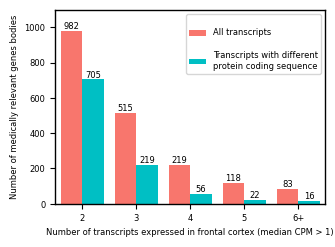

In [91]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_med_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True)


# replace labels 
legend = ax.legend()
legend.texts[0].set_text("\nAll transcripts\n")
legend.texts[1].set_text("Transcripts with different\nprotein coding sequence")
    
ax.set(ylim=(0, 1100), xlim=(-0.5, 4.5))
plt.ylabel("Number of medically relevant genes bodies")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])    


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/C.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/C.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [92]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_brain = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_brain = df_gene_brain.loc[df_gene_brain.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_median = df_gene_mutiple_brain["gene_name"].value_counts()


## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_brain_multiple_iso = pd.DataFrame()
df_num_brain_multiple_iso["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_median.value_counts()
df_num_brain_multiple_iso["Number of transcripts"] = df_numbers_brain_multiple_isoforms_median.value_counts().index
df_num_brain_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso_six.groupby("Category").sum()
df_num_brain_multiple_iso_six["Number of transcripts"] = "6+"
df_num_brain_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_brain_multiple_iso = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] < 6].copy()
df_num_brain_multiple_iso["Number of transcripts"] = df_num_brain_multiple_iso["Number of transcripts"].astype(str)
df_num_brain_multiple_iso = pd.concat([df_num_brain_multiple_iso, df_num_brain_multiple_iso_six])

In [93]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_coding_ccds = df_prot_coding_ccds.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")
df_prot_coding_ccds.drop_duplicates(inplace=True)
df_gene_mutiple_brain_prot = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()


df_gene_mutiple_brain_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_brain_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[~df_gene_mutiple_brain_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[df_gene_mutiple_brain_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_prot_median = df_gene_mutiple_brain_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_brain = pd.DataFrame()
df_num_isoforms_prot_brain["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_brain["Number of transcripts"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_brain["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain_six.groupby("Category").sum()
df_num_isoforms_prot_brain_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_brain_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_brain = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_brain["Number of transcripts"] = df_num_isoforms_prot_brain["Number of transcripts"].astype(str)
df_num_isoforms_prot_brain = pd.concat([df_num_isoforms_prot_brain, df_num_isoforms_prot_brain_six])

In [94]:
## Concatenate
df_number_brain_isoforms_per_gene = pd.concat([df_num_brain_multiple_iso, df_num_isoforms_prot_brain])

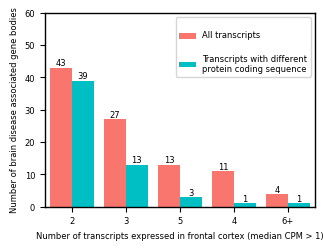

In [95]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_brain_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True)


# replace labels   
legend = ax.legend()
legend.texts[0].set_text("\nAll transcripts\n")
legend.texts[1].set_text("Transcripts with different\nprotein coding sequence")

ax.set(ylim=(0, 60), xlim=(-0.5, 4.5))
plt.ylabel("Number of brain disease associated gene bodies")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])    


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/D.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/D.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [96]:
## Create disease panels
ad_panel = ["BIN1", "TNIP1", "APP", "ADAM17", "EED", "SHARPIN", "PSEN1", "ANK3", "MAPT", "BCKDK"]

pd_als_ftd_late_panel = ["SNCA", "ASXL3", "RIMS1", "GPNMB", "CLCN3", "SOD1", "VCP", "KIF5A", "TARDBP", "ABCC9"]

asd_sud_mdd_schizo = ["ANK2", "ARID1B", "SHANK3", "ADD1", "RHOA", "CTNND1", "MAOA", "PCLO", "CACNA1G", "GRIA3"]

In [97]:
## Create dataframe for AD panel
df_numbers_brain_multiple_iso = df_gene_mutiple_brain["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')
df_numbers_brain_multiple_prot = df_gene_mutiple_brain_prot["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')

df_numbers_ad_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(ad_panel)].copy()
df_numbers_ad_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(ad_panel)].copy()

df_numbers_ad_iso["Category"] = "All transcripts"
df_numbers_ad_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_ad = pd.concat([df_numbers_ad_iso, df_numbers_ad_prot])

ad_psen = pd.DataFrame(data={"gene_name": ["PSEN1"], "Number of transcripts": [1], 
                              "Category": ["Transcripts with different protein coding sequence"]})

df_numbers_ad = pd.concat([df_numbers_ad, ad_psen])

In [98]:
## Create dataframe for PD + ALS/FTD + LATE panel
df_numbers_pd_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(pd_als_ftd_late_panel)].copy()
df_numbers_pd_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(pd_als_ftd_late_panel)].copy()

df_numbers_pd_iso["Category"] = "All transcripts"
df_numbers_pd_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_pd = pd.concat([df_numbers_pd_iso, df_numbers_pd_prot])

pd_pink1 = pd.DataFrame(data={"gene_name": ["SNCA"], "Number of transcripts": [1], 
                              "Category": ["Transcripts with different protein coding sequence"]})

df_numbers_pd = pd.concat([df_numbers_pd, pd_pink1])

In [99]:
## Create dataframe for PD + ALS/FTD + LATE panel
df_numbers_asd_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(asd_sud_mdd_schizo)].copy()
df_numbers_asd_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(asd_sud_mdd_schizo)].copy()

df_numbers_asd_iso["Category"] = "All transcripts"
df_numbers_asd_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_asd = pd.concat([df_numbers_asd_iso, df_numbers_asd_prot])

pd_maoa = pd.DataFrame(data={"gene_name": ["MAOA", "ANK2"], "Number of transcripts": [1, 1], 
                              "Category": ["Transcripts with different protein coding sequence", 
                                          "Transcripts with different protein coding sequence"]})

df_numbers_asd = pd.concat([df_numbers_asd, pd_maoa])

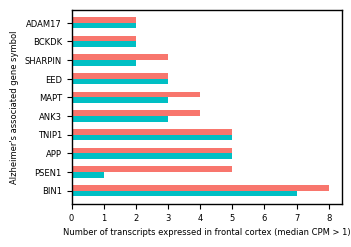

In [100]:
## Make AD panel
ax = sns.barplot(data=df_numbers_ad, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                width=0.6, hue_order=["Transcripts with different protein coding sequence", "All transcripts"])

ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("Alzheimer's associated gene symbol")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/E.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/E.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

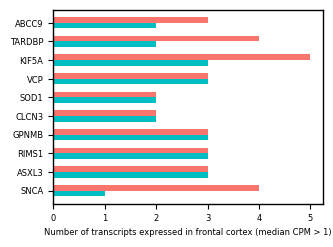

In [101]:
## Make PD + ALS/FTD + LATE panel
ax = sns.barplot(data=df_numbers_pd, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                order=pd_als_ftd_late_panel, width=0.6,
                 hue_order=["Transcripts with different protein coding sequence", "All transcripts"])


ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/F.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/F.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

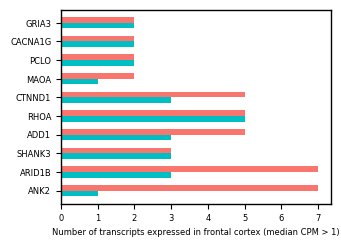

In [102]:
## Make PD + ALS/FTD + LATE panel
ax = sns.barplot(data=df_numbers_asd, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                order=asd_sud_mdd_schizo, width=0.6, 
                hue_order=["Transcripts with different protein coding sequence", "All transcripts"])


ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("Number of transcripts expressed in frontal cortex (median CPM > 1)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/G.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/G.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Figure 6

In [103]:
## Get number of transcripts from each filter from each filter

print("Number of transcripts mapping to new gene bodies (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of new transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (no filter): 1860
Number of transcripts mapping to new gene bodies (median CPM > 1): 267


Number of new transcripts mapping to annotated genes (no filter): 1534
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [104]:
## Get number of genes represented for each filter

print("Number of new genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with new transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (no filter): 1676
Number of new genes represented (median CPM > 1): 245


Number of represented annotated genes with new transcripts (no filter): 1255
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [105]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntng_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntng_median_cpm = df_novel_genes.loc[df_novel_genes["median_CPM"] >= cpm_thresh].copy()
    ntng_median_cpm_num = ntng_median_cpm.shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
        
    list_ntng_median.append(ntng_median_cpm_num)

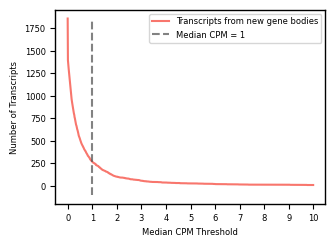

In [106]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntng_median, color=ggplot2_colors[0], label="Transcripts from new gene bodies", linewidth=1.5, alpha=1)
plt.plot([1, 1], [-100, 1850], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=0.7, linestyle='dashed')

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/A.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/A.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [107]:
list_ntng_median[101]

267

In [108]:
list_cpm_thresh[101]

1.01

In [109]:
novel_genes_ref = ref.loc[ref["gene_id"].str.startswith("BambuGene")].copy()
novel_genes_ref = novel_genes_ref.loc[novel_genes_ref["type"] == "transcript"].copy()
novel_genes_ref["gene_name"] = np.nan

novel_genes_ref.drop(columns="exon_number", inplace=True)

In [110]:
df_overlapping_novel_genes_same = pd.DataFrame(columns=['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                               'end', 'strand', "overlapping", "category"])

df_overlapping_novel_genes_opp = pd.DataFrame(columns=['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                               'end', 'strand', "overlapping", "category"])

for index in novel_genes_ref.index:
    
    df_transcript = novel_genes_ref.loc[novel_genes_ref.index == index].copy()
    
    transcript_id = df_transcript["transcript_id"].iloc[0]
    
    df_transcript = df_transcript[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 'end', 'strand']].copy()
    
    start = df_transcript["start"].iloc[0]
    end = df_transcript["end"].iloc[0]
    chrom = df_transcript["chr"].iloc[0]
    strand = df_transcript["strand"].iloc[0]
    
    df_overlapping_genes_opp = orig_ref.loc[((orig_ref["chr"] == chrom) & ((start < orig_ref["end"]) &  (end > orig_ref["start"])) & (strand != orig_ref["strand"]))]
    df_overlapping_genes_same = orig_ref.loc[((orig_ref["chr"] == chrom) & ((start < orig_ref["end"]) &  (end > orig_ref["start"])) & (strand == orig_ref["strand"]))]
    
    if df_overlapping_genes_opp.shape[0] > 0:
    
        df_overlapping_genes_opp = df_overlapping_genes_opp[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                                   'end', 'strand']].copy()

        df_overlapping_genes_opp["overlapping"] = transcript_id
        df_transcript["overlapping"] = transcript_id
        df_overlapping_genes_opp["category"] = "overlapping_gene"
        df_transcript["category"] = "new_gene_body"

        df_overlapping_novel_genes_opp = pd.concat([df_overlapping_novel_genes_opp, df_overlapping_genes_opp])
        
    elif df_overlapping_genes_same.shape[0] > 0:
        
        df_overlapping_genes_same = df_overlapping_genes_same[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                           'end', 'strand']].copy()

        df_overlapping_genes_same["overlapping"] = transcript_id
        df_transcript["overlapping"] = transcript_id
        df_overlapping_genes_same["category"] = "overlapping_gene"
        df_transcript["category"] = "new_gene_body"

        df_overlapping_novel_genes_same = pd.concat([df_overlapping_novel_genes_same, df_overlapping_genes_same])

In [111]:
all_overlapping_id_list = []

all_overlapping_id_list += df_overlapping_novel_genes_opp["overlapping"].unique().tolist()
all_overlapping_id_list += df_overlapping_novel_genes_same["overlapping"].unique().tolist()

In [112]:
non_overlapping_new_genes = novel_genes_ref.loc[~novel_genes_ref["transcript_id"].isin(all_overlapping_id_list)].copy()

In [113]:
df_overlapping_novel_genes_opp.head()

,gene_id,gene_name,chr,source,type,start,end,strand,overlapping,category
307717,ENSG00000217801,NaN,1,havana,gene,1059687.0,1069355.0,+,BambuTx2705,overlapping_gene
517,ENSG00000157933,SKI,1,ensembl_havana,gene,2228319.0,2310213.0,+,BambuTx3360,overlapping_gene
12407,ENSG00000116151,MORN1,1,ensembl_havana,gene,2321253.0,2391707.0,-,BambuTx8,overlapping_gene
127,ENSG00000228037,NaN,1,havana,gene,2581560.0,2584533.0,+,BambuTx3064,overlapping_gene
2627,ENSG00000225931,NaN,1,havana,gene,2566410.0,2569888.0,+,BambuTx3064,overlapping_gene


In [114]:
list_number_of_transcripts = [non_overlapping_new_genes["transcript_id"].nunique(),
                              df_overlapping_novel_genes_opp["overlapping"].nunique(),
                             df_overlapping_novel_genes_same["overlapping"].nunique()]


list_categories = ["Not overlapping any gene bodies",
                  "Overlapping gene body on opposite strand",
                  "Overlapping gene body on same strand, but no exon overlap"]

dict_new_genes = {"Count": list_number_of_transcripts, "Category": list_categories}

df_new_genes_counts = pd.DataFrame(data=dict_new_genes)

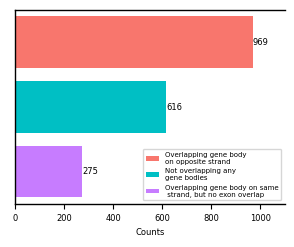

In [115]:
## Make graph of new transcript events for no filter

ax = sns.barplot(data=df_new_genes_counts, y="Category", hue="Category", x="Count", dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[4], ggplot2_colors[6]],
                   saturation=1, order=df_new_genes_counts.sort_values(by="Count", ascending=False)["Category"],
                hue_order=df_new_genes_counts.sort_values(by="Count", ascending=False)["Category"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 1100)

sns.despine(ax=ax, top=False, right=True, left=False, bottom=False, offset=None, trim=False)

plt.yticks(rotation=90)
plt.tick_params(labelsize=None)

new_labels = ['Overlapping gene body \non opposite strand', 'Not overlapping any \ngene bodies',
             "Overlapping gene body on same\n strand, but no exon overlap"]
plt.legend(fontsize=5)
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/B.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/B.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [116]:
new_gene_tids_median = df_novel_genes_median["transcript_id"].tolist()

In [117]:
df_overlapping_novel_genes_opp_median = df_overlapping_novel_genes_opp.loc[df_overlapping_novel_genes_opp["overlapping"].isin(new_gene_tids_median)].copy()
df_overlapping_novel_genes_same_median = df_overlapping_novel_genes_same.loc[df_overlapping_novel_genes_same["overlapping"].isin(new_gene_tids_median)].copy()
non_overlapping_new_genes_median = non_overlapping_new_genes.loc[non_overlapping_new_genes["transcript_id"].isin(new_gene_tids_median)].copy()

In [118]:
list_number_of_transcripts = [non_overlapping_new_genes_median["transcript_id"].nunique(),
                              df_overlapping_novel_genes_opp_median["overlapping"].nunique(),
                             df_overlapping_novel_genes_same_median["overlapping"].nunique()]


list_categories = ["Not overlapping any gene bodies",
                  "Overlapping gene body on opposite strand",
                  "Overlapping gene body on same strand, but no exon overlap"]

dict_new_genes = {"Count": list_number_of_transcripts, "Category": list_categories}

df_new_genes_counts_median = pd.DataFrame(data=dict_new_genes)

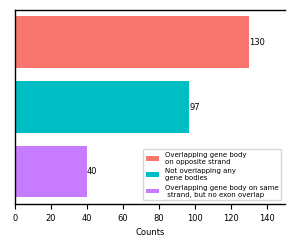

In [119]:
## Make graph of new transcript events for no filter

ax = sns.barplot(data=df_new_genes_counts_median, y="Category", hue="Category", x="Count", dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[4], ggplot2_colors[6]],
                   saturation=1, order=df_new_genes_counts_median.sort_values(by="Count", ascending=False)["Category"],
                hue_order=df_new_genes_counts_median.sort_values(by="Count", ascending=False)["Category"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 150)

sns.despine(ax=ax, top=False, right=True, left=False, bottom=False, offset=None, trim=False)

plt.yticks(rotation=90)
plt.tick_params(labelsize=None)

new_labels = ['Overlapping gene body \non opposite strand', 'Not overlapping any \ngene bodies',
             "Overlapping gene body on same\n strand, but no exon overlap"]
plt.legend(fontsize=5)
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/C.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/C.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

## - Figure 7

In [120]:
## Get all transcript IDs from ENSEMBL 94 GTF

df_ensembl_94 = ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.94.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

df_ensembl_94 = df_ensembl_94.loc[~df_ensembl_94["chr"].str.startswith("ERCC-")]

df_ensembl_94_transcripts = df_ensembl_94.loc[df_ensembl_94["type"] == "transcript"].copy()

df_ensembl_94_transcripts = parse_df_columns(df_ensembl_94_transcripts, is_ref=True, is_transcript=True)

ensembl_94_transcript_ids = df_ensembl_94_transcripts["transcript_id"].copy()

In [121]:
## Get transcript names from ENSEMBL 107 GTF

ensembl_107_transcripts = original_ref.loc[original_ref["type"] == "transcript"].copy()
ensembl_107_transcripts = parse_df_columns(ensembl_107_transcripts, is_ref=True, is_transcript=True)

In [122]:
## Only keep transcripts that are different between ensembl_94 and ensembl_107

ensembl_107_exclusive_transcripts = ensembl_107_transcripts.loc[~ensembl_107_transcripts["transcript_id"].isin(ensembl_94_transcript_ids)].copy()

In [123]:
## Create list of new CCDS since 2019

## Get all transcript IDs from ENSEMBL 94 GTF
df_ensembl_94_cds = df_ensembl_94_transcripts.merge(ref_cds, how="inner", on="transcript_id").dropna(subset="protein_id")
ensembl_94_cds_protein_ids = df_ensembl_94_cds["protein_id"].copy()

## Get transcript names from ENSEMBL 107 GTF
ensembl_107_cds = ensembl_107_transcripts.merge(ref_cds, how="inner", on="transcript_id")
ensembl_107_cds.dropna(subset="protein_id", inplace=True)

## Get ensmbl 107 exclusive ccds
ensembl_107_exclusive_ccds = ensembl_107_cds.loc[~ensembl_107_cds["transcript_id"].isin(ensembl_94_transcript_ids)].copy()
ensembl_107_exclusive_ccds = ensembl_107_exclusive_ccds.loc[~ensembl_107_exclusive_ccds["protein_id"].isin(ensembl_94_cds_protein_ids)].copy()

In [124]:
## Create counts matrix only including the new transcripts found after ENSEMBL 94

df_exclusive_107_transcripts = df.loc[df["transcript_id"].isin(ensembl_107_exclusive_transcripts["transcript_id"])].copy()
df_exclusive_107_ccds = df.loc[df["transcript_id"].isin(ensembl_107_exclusive_ccds["transcript_id"])].copy()

In [125]:
df_exclusive_107_transcripts.shape

(48155, 17)

In [126]:
df_exclusive_107_ccds.shape

(6424, 17)

In [127]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds

list_cpm_thresh = []

list_ensembl_107_all_transcript_median = []
list_ensembl_107_new_cds_transcript_median = []
list_ensembl_107_med_relevant_transcript_median = []
list_ensembl_107_med_relevant_new_cds_transcript_median = []
list_ensembl_107_brain_relevant_transcript_median = []
list_ensembl_107_brain_relevant_new_cds_transcript_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ensembl_107_median = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] >= cpm_thresh].copy()
    ensembl_107_new_cds_median = df_exclusive_107_ccds.loc[df_exclusive_107_ccds["median_CPM"] >= cpm_thresh].copy()
    ensembl_107_med_relevant_median = ensembl_107_median.loc[ensembl_107_median["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
    ensembl_107_med_relevant_new_cds_median = ensembl_107_med_relevant_median.loc[ensembl_107_med_relevant_median["transcript_id"].isin(ensembl_107_new_cds_median["transcript_id"])].copy()
    ensembl_107_brain_relevant_median = ensembl_107_median.loc[ensembl_107_median["gene_id"].isin(brain_disease_gene_ids["gene_id"])].copy()
    ensembl_107_brain_relevant_new_cds_median = ensembl_107_brain_relevant_median.loc[ensembl_107_brain_relevant_median["transcript_id"].isin(ensembl_107_new_cds_median["transcript_id"])].copy()
    
    
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ensembl_107_all_transcript_median.append(ensembl_107_median.shape[0])
    list_ensembl_107_new_cds_transcript_median.append(ensembl_107_new_cds_median.shape[0])
    list_ensembl_107_med_relevant_transcript_median.append(ensembl_107_med_relevant_median.shape[0])
    list_ensembl_107_med_relevant_new_cds_transcript_median.append(ensembl_107_med_relevant_new_cds_median.shape[0])
    list_ensembl_107_brain_relevant_transcript_median.append(ensembl_107_brain_relevant_median.shape[0])
    list_ensembl_107_brain_relevant_new_cds_transcript_median.append(ensembl_107_brain_relevant_new_cds_median.shape[0])

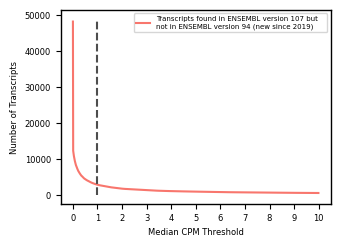

In [128]:
plt.plot(list_cpm_thresh, list_ensembl_107_all_transcript_median, color=ggplot2_colors[0], label="New transcripts since 2019", linewidth=1.5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(labels=["Transcripts found in ENSEMBL version 107 but   \nnot in ENSEMBL version 94 (new since 2019)   "], 
           loc="upper right", fontsize=5)
plt.plot([1, 1], [-10, 49000], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/A.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/A.svg', dpi=1200, transparent=True, bbox_inches="tight")


In [158]:
list_ensembl_107_all_transcript_median[101]

2797

In [129]:
df_exclusive_107_transcripts_median = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] > 0].copy()

df_exclusive_107_transcripts_median["Log10 median CPM"] = np.log10(df_exclusive_107_transcripts_median["median_CPM"])

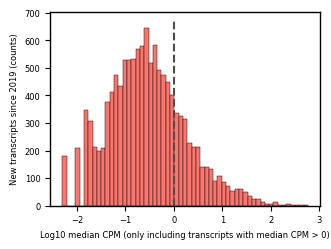

In [130]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exclusive_107_transcripts_median["Log10 median CPM"], color=ggplot2_colors[0], alpha=1)

plt.plot([0, 0], [0, 670], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')

plt.xlabel("Log10 median CPM (only including transcripts with median CPM > 0)")
plt.ylabel("New transcripts since 2019 (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/B.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/B.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

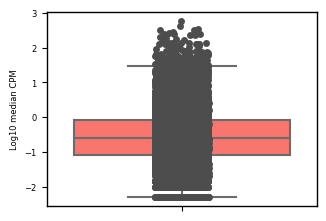

In [131]:
ax = sns.boxplot(data=df_exclusive_107_transcripts_median, y="Log10 median CPM",
                 saturation=1, dodge=False, showfliers=False, color=ggplot2_colors[0])

sns.stripplot(data=df_exclusive_107_transcripts_median, y="Log10 median CPM", color="#4d4d4d")


#ax.set(ylim=(-10, 110))
#ax.set(xlim=(-1.3, 5.3))
#ax.set(xticklabels=[], ylabel="Relative Abundance of \n New Transcripts Since 2019 (%)", xlabel="", )


#plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/D.png', dpi=1200, transparent=True, bbox_inches="tight")
#plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/D.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [132]:
ensembl_107_median_1 = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] > 1].copy()
ensembl_107_new_cds_median_1 = df_exclusive_107_ccds.loc[df_exclusive_107_ccds["median_CPM"] > 1].copy()

ensembl_107_med_relevant_median_1 = ensembl_107_median_1.loc[ensembl_107_median_1["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
ensembl_107_med_relevant_new_cds_median_1 = ensembl_107_med_relevant_median_1.loc[ensembl_107_med_relevant_median_1["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])].copy()

ensembl_107_brain_relevant_median_1 = ensembl_107_median_1.loc[ensembl_107_median_1["gene_id"].isin(brain_disease_gene_ids["gene_id"])].copy()
ensembl_107_brain_relevant_new_cds_median_1 = ensembl_107_brain_relevant_median_1.loc[ensembl_107_brain_relevant_median_1["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])].copy()

In [133]:
df_barplot_107 = pd.DataFrame()

df_barplot_107["New Transcript Since 2019 (Median CPM > 1)"] = [ensembl_107_med_relevant_median_1.shape[0], ensembl_107_new_cds_median_1.shape[0],
                                                                ensembl_107_med_relevant_new_cds_median_1.shape[0],
                                               ensembl_107_brain_relevant_median_1.shape[0], ensembl_107_brain_relevant_new_cds_median_1.shape[0]]

df_barplot_107["Description"] = ["Med-relevant", "New protein coding sequence", "Med-relevant new protein coding sequence", 
                                "Brain disease relevant", "Brain disease relevant new protein\ncoding sequence"]

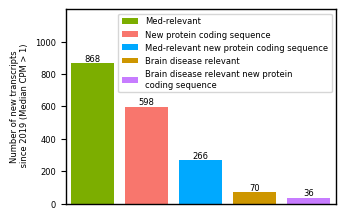

In [134]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_barplot_107, y="New Transcript Since 2019 (Median CPM > 1)", x="Description", hue="Description",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, order=["Med-relevant", "New protein coding sequence", "Med-relevant new protein coding sequence", 
                                "Brain disease relevant", "Brain disease relevant new protein\ncoding sequence"])
for container in ax.containers:
    ax.bar_label(container)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
    
ax.set(ylim=(0, 1199))
plt.ylabel('Number of new transcripts\n since 2019 (Median CPM > 1)')
ax.set(xticklabels=[], xlabel="")
ax.tick_params(bottom=False)
plt.legend(fontsize=6, loc="upper right")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/C.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/C.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [135]:
## Create dataframe to store percent expression
percent_expression_df = pd.DataFrame()

In [136]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_med_relevant_median_1["gene_id"])].copy()
med_relevant_relative_abundance = relative_transcript_abundance(med_percent_expression)

med_final_percent_expression = med_relevant_relative_abundance.loc[med_relevant_relative_abundance["transcript_id"].isin(ensembl_107_med_relevant_median_1["transcript_id"])]
med_final_percent_expression = med_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_final_percent_expression = med_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [137]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()

cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_new_cds_median_1["gene_id"])].copy()
cds_relevant_relative_abundance = relative_transcript_abundance(cds_percent_expression)

cds_final_percent_expression = cds_relevant_relative_abundance.loc[cds_relevant_relative_abundance["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])]
cds_final_percent_expression = cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
cds_final_percent_expression = cds_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "New protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [138]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_med_relevant_new_cds_median_1["gene_id"])].copy()
med_cds_relevant_relative_abundance = relative_transcript_abundance(med_cds_percent_expression)

med_cds_final_percent_expression = med_cds_relevant_relative_abundance.loc[med_cds_relevant_relative_abundance["transcript_id"].isin(ensembl_107_med_relevant_new_cds_median_1["transcript_id"])]
med_cds_final_percent_expression = med_cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_cds_final_percent_expression = med_cds_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [139]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


brain_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_brain_relevant_median_1["gene_id"])].copy()
brain_relevant_relative_abundance = relative_transcript_abundance(brain_percent_expression)

brain_final_percent_expression = brain_relevant_relative_abundance.loc[brain_relevant_relative_abundance["transcript_id"].isin(ensembl_107_brain_relevant_median_1["transcript_id"])]
brain_final_percent_expression = brain_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
brain_final_percent_expression = brain_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = brain_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = brain_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = brain_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Brain disease relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [140]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


brain_new_prot_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_brain_relevant_new_cds_median_1["gene_id"])].copy()
brain_new_prot_relevant_relative_abundance = relative_transcript_abundance(brain_new_prot_percent_expression)

brain_new_prot_final_percent_expression = brain_new_prot_relevant_relative_abundance.loc[brain_new_prot_relevant_relative_abundance["transcript_id"].isin(ensembl_107_brain_relevant_new_cds_median_1["transcript_id"])]
brain_new_prot_final_percent_expression = brain_new_prot_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
brain_new_prot_final_percent_expression = brain_new_prot_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = brain_new_prot_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = brain_new_prot_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = brain_new_prot_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Brain disease relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

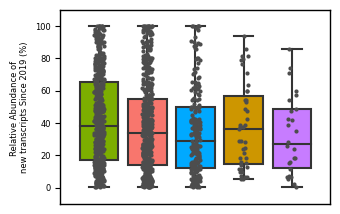

In [141]:
ax = sns.boxplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category", 
                 hue="Category",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category",
             color="#4d4d4d", size=3)


ax.set(ylim=(-10, 110))
ax.set(xlim=(-0.8, 4.8))
ax.set(xticklabels=[], ylabel="Relative Abundance of \nnew transcripts Since 2019 (%)", xlabel="")
ax.tick_params(bottom=False)

plt.legend([],[], frameon=False)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/D.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/D.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [142]:
brain_disease_relevant_since_2019 = percent_expression_df.loc[percent_expression_df["Category"
                                                            ].str.contains("Brain disease relevant new")]

brain_disease_relevant_since_2019.columns = ["gene_id", "Gene Name", "Relative Abundance of New Transcripts Since 2019 (%)",
                                            "Category"]

brain_disease_relevant_since_2019 = brain_disease_relevant_since_2019.merge(
                                        brain_disease_annotations, on="gene_id", how="inner")

In [143]:
brain_relevant_new_cds_gene_list = ["ADAM17", "ABCA1", "GBF1", "ASXL3", "KIF5A", "VCP", "SHANK3", "SOX6", "CTNND1", "RHOA"]

brain_relevant_new_cds_examples = percent_expression_df.loc[percent_expression_df["Category"] == "Brain disease relevant new protein coding sequence"].copy()
brain_relevant_new_cds_examples = brain_relevant_new_cds_examples.loc[brain_relevant_new_cds_examples["Gene Name"].isin(brain_relevant_new_cds_gene_list)]

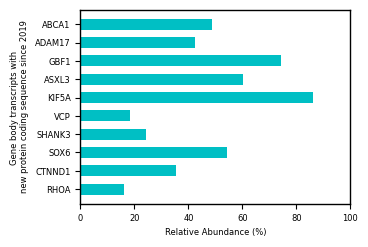

In [144]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=brain_relevant_new_cds_examples, y="Gene Name", x="Relative Abundance of New Transcripts Since 2019 (%)",
            palette=[ggplot2_colors[4]], saturation=1, 
            order=["ABCA1", "ADAM17", "GBF1", "ASXL3", "KIF5A", "VCP", "SHANK3", "SOX6", "CTNND1", "RHOA"],
            width=0.6)

ax.set(xlim=(0, 100))
plt.xlabel("Relative Abundance (%)")
plt.ylabel("Gene body transcripts with \nnew protein coding sequence since 2019")
ax.set_ylim(9.8, -0.8)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/E.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_7/E.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Memes for figures

In [145]:
## Set size of figure in mm
rcParams['figure.figsize'] = (102*mm, 64*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [146]:
### 3 PRIME NFN ###

nfn_3_prime_in = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_3_prime_in.readlines()


nfn_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        nfn_3_prime_out.write(Lines_in[i-1])
        nfn_3_prime_out.write(Lines_in[i])
        
nfn_3_prime_out.close()

nfn_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_3_prime_out.readlines()

percent_3_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfn_3_prime_out.close()

In [147]:
### 5 PRIME NFN ###

nfn_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_5_prime_in.readlines()

nfn_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to filesf
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfn_5_prime_out.write(Lines_in[i-1])
        nfn_5_prime_out.write(Lines_in[i])
        
nfn_5_prime_out.close()

nfn_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_5_prime_out.readlines()

percent_5_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfn_5_prime_out.close()

In [148]:
### 5 PRIME NFK ###

nfk_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_nfki_12s.fa", 'r')
Lines_in = nfk_5_prime_in.readlines()

nfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfk_5_prime_out.write(Lines_in[i-1])
        nfk_5_prime_out.write(Lines_in[i])
        
nfk_5_prime_out.close()

nfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'r')
Lines_out = nfk_5_prime_out.readlines()

percent_5_nfk = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfk_5_prime_out.close()

In [149]:
### 5 PRIME KFK ###

kfk_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s.fa", 'r')
Lines_in = kfk_5_prime_in.readlines()

kfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        kfk_5_prime_out.write(Lines_in[i-1])
        kfk_5_prime_out.write(Lines_in[i])
        
kfk_5_prime_out.close()

kfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'r')
Lines_out = kfk_5_prime_out.readlines()

percent_5_kfk = round((len(Lines_out)/len(Lines_in)) * 100, 4)

kfk_5_prime_out.close()

In [150]:
### 3 PRIME NFM ###

nfm_3_prime_in = open("../../../data/maddy/MEME/three_prime_splice_sites_nfm_12s.fa", 'r')
Lines_in = nfm_3_prime_in.readlines()


nfm_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfm_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        nfm_3_prime_out.write(Lines_in[i-1])
        nfm_3_prime_out.write(Lines_in[i])
        
nfm_3_prime_out.close()

nfm_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfm_12s_VALIDATED.fa", 'r')
Lines_out = nfm_3_prime_out.readlines()

percent_3_nfm = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfm_3_prime_out.close()

In [151]:
### 5 PRIME NFM ###

nfm_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_nfm_12s.fa", 'r')
Lines_in = nfm_5_prime_in.readlines()

nfm_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfm_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfm_5_prime_out.write(Lines_in[i-1])
        nfm_5_prime_out.write(Lines_in[i])
        
nfm_5_prime_out.close()

nfm_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfm_12s_VALIDATED.fa", 'r')
Lines_out = nfm_5_prime_out.readlines()

percent_5_nfm = round((19/(len(Lines_in)/2)) * 100, 4)

nfm_5_prime_out.close()

In [152]:
five_prime_kfk = percent_5_kfk
three_prime_kfk = round((160025/160416) * 100, 4)

five_prime_nfk = percent_5_nfk
three_prime_nfk = round((479/479) * 100, 4)

five_prime_nfn = percent_5_nfn
three_prime_nfn = percent_3_nfn

five_prime_nfm = percent_5_nfm
three_prime_nfm = percent_3_nfm

In [153]:
dict_nfk = {"Percent exons containing motiff": [five_prime_nfk, five_prime_kfk, three_prime_nfk, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for known gene body", "Annotated transcripts", "New transcripts for known gene body", "Annotated transcripts"]}

df_nfk = pd.DataFrame(dict_nfk)



dict_nfn = {"Percent exons containing motiff": [five_prime_nfn, five_prime_kfk, three_prime_nfn, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for new gene body", "Annotated transcripts", "New transcripts for new gene body", "Annotated transcripts"]}

df_nfn = pd.DataFrame(dict_nfn)



dict_nfm = {"Percent exons containing motiff": [five_prime_nfm, five_prime_kfk, three_prime_nfm, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for mitochondria", "Annotated transcripts", "New transcripts for mitochondria", "Annotated transcripts"]}

df_nfm = pd.DataFrame(dict_nfm)

/tmp/ipykernel_1379734/1598857993.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")


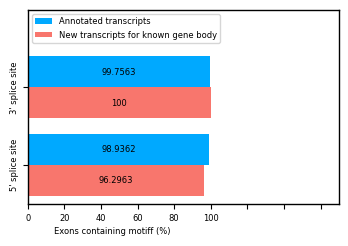

In [154]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_nfk, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[0], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.27, -0.12)

ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")
ax.set_yticklabels(labels=["5' splice site\n", "3' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/MEME.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/MEME.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

/tmp/ipykernel_1379734/240594286.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")


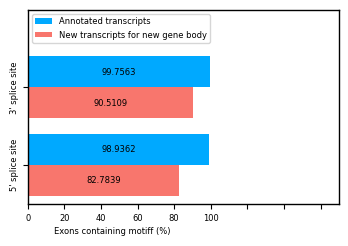

In [155]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_nfn, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[0], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.27, -0.12)

ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")
ax.set_yticklabels(labels=["5' splice site\n", "3' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/MEME.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_6/MEME.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

/tmp/ipykernel_1379734/976322084.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")


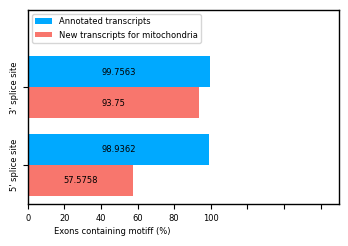

In [156]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_nfm, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[0], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.27, -0.12)

ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")
ax.set_yticklabels(labels=["5' splice site\n", "3' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')
plt.savefig('../../../figures/bernardo/01.exploratory_analysis/mito/MEME.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/01.exploratory_analysis/mito/MEME.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()